## 군집화 실습
#### 고객 세그먼테이션 (Custoemr Segmentation)
- 다양한 기준으로 고객을 분류하는 기법
- CRM이나 마케팅의 중요기반요소로 사용

#### 고객 분류 요소
- 개인 신상데이터 기반 : 지역/결혼여부/성별/소득 등
- 영업정보 기반 : 기업 입장에서는 더 중요한 요소
    - 구매정보 기반
        - 어떤 상품을
        - 얼마나 많은 비용을 들여서
        - 얼마나 자주 구매했는가?

고객 세그먼테이션의 주요 목표 : 타깃 마케팅

고객 세그먼테이션 군집화
- 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요
- 예제 : 기본적인 고객 분석 요소인 FRM 기법 이용 

FRM 기법
- Recency(R) : 가장 최근 상품구입일에서 오늘까지의 기간
- Frequency(F) : 상품 구매 횟수
- Monetary Value(M) : 총 구매 금액

### 고객 세그먼테이션 예제 
- 온라인 판매 데이터를 기반으로  
    - 고객 세그먼테이션을 군집화 기반으로 수행  

사용 데이터 
- UCI : Machine Learning Repository에서 다운로드
- http://archive.ics.uci.edu/ml/datasets/online+retail
- Datasets 
- Online Retail.xslx
- 제품 주문 데이터 세트  

### 고객 세그먼테이션 군집화 과정

- 데이터 세트 로딩과 데이터 클린징
    - 반품데이터 포함되어 있으므로, 처리 방법 결정 필요
    - 고객을 구분할 수 있는 정보가 반드시 있어야함
        - 구분정보가 없는 샘플은 제거
- RFM 기반 데이터 가공
    - 주문 내역을 이용해서 구매금액 데이터 생성
    - 주문기준 >> 고객 기준정보로 변경해야함

- RFM 기반 고객 세그먼테이션
    - 군집화(K-means)
    - 군집화 평가(실루엣 분석)
    - 적당한 군집 결정
- 시각화 통해서 간단한 군집 특성 확인

### 데이터 세트 로딩과 전처리 작업

In [71]:
# !pip install openpyxl
# 아마콘다 가상환경에서 설치

In [72]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
retail_df_origin = pd.read_excel('./data/Online Retail.xlsx')
retail_df_origin.head()
retail_df_origin.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [74]:
retail_df = retail_df_origin.copy()

In [75]:
# 데이터 확인
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 주문 기준 data
- 주문번호, 제폼코드, 설명, 수량, 주문일, 단가, 주문고객ID, 주문국가
- 한개 주문서에 여러개의 상품 주문이 가능
    - 식별자(key) : InvoiceNo + StockCode

In [76]:
# 기초 통계 정보 확인
retail_df.describe()
# 주문수량에 음수가 존재 : -80995
# 단가에도 음수가 존재 : -11062

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [77]:
# 주문수량이 음수 있는지 확인 : 음수인 데이터 출력
retail_df[retail_df["Quantity"]<0]

# 10624 샘플이 음수 수량 >> 반품 예상
# 수량이 음수일때, InvoiceNo가 C 로 시작함

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [78]:
# 가격이 음수 있는지 확인 : 음수인 데이터 출력
retail_df[retail_df["UnitPrice"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


### 전처리 작업 필요

- CustomerID   
    - 고객 식별번호 없는 데이터는 삭제
- Quantity와 UnitPrice에 음수값 존재 (반품)  
    - 양수값만 사용
- 영국 데이터만 사용
    - 데이터 기준 국내 고객만을 세그멘테이션 진행

#### 음수값, CustomerID가 Null인 데이터, 영국 이외의 국가 데이터는 제외

In [79]:
# Quantity와 UnitPrice에 음수값 포함된 데이터와  CustomerID가 Null삭제
retail_df = retail_df[retail_df["Quantity"]>0]
retail_df = retail_df[retail_df["UnitPrice"]>0]
retail_df = retail_df.dropna(subset=["CustomerID"])

# 크기 확인
retail_df.shape

# null 있는지 확인
retail_df.isnull().sum()


(397884, 8)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [80]:
# 주문 고객 나라별 주문수 확인
# 각 나라별 몇 건씩 있는 지 확인
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

In [81]:
# 영국 외의 다른 국가 삭제
retail_df = retail_df[retail_df["Country"]=="United Kingdom"]
retail_df.shape
retail_df["Country"].value_counts()

(354321, 8)

Country
United Kingdom    354321
Name: count, dtype: int64

In [82]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

### RFM 기반 데이터 가공

- 고객 세그먼테이션 군집화를 RFM 기반으로 수행하는 데 필요한 데이터 가공  
- Recency, Frequency, Monetary  

In [83]:
# 구매 금액 계산해서 df에 추가
retail_df['SaleAmount'] =  retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [84]:
# 고객번호 (CustomerID) 수치인데 float : Null 값이 포함되어 있기 때문
# 고객번호가 Null 인 데이터 삭제했으로
# 고객번호 (CustomerID)를 편리하게 식별하기 위해 float형을 int 형으로 변환
retail_df['CustomerID'] = retail_df["CustomerID"].astype(int)
retail_df['CustomerID'].head(2)

0    17850
1    17850
Name: CustomerID, dtype: int64

In [85]:
# 주문한 적이 있는 고객 수 확인
# 주문한 적이 있는 고객 : 주문 df에 존재하는 고객
retail_df["CustomerID"].nunique()

3920

In [86]:
# 고객별 주문 건수 확인 : 상위 5위 확인
retail_df["CustomerID"].value_counts().head()
# 고객별 주문 건수 확인 : 하위 5위 확인
retail_df["CustomerID"].value_counts().tail()

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64

CustomerID
16148    1
16073    1
16738    1
15195    1
13747    1
Name: count, dtype: int64

In [87]:
# 고객별 주문액 상위 5위 확인 
retail_df.groupby(by="CustomerID")["SaleAmount"].sum().sort_values(ascending=False).head()
retail_df.groupby(by="CustomerID")["SaleAmount"].sum().sort_values(ascending=False).tail()

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: SaleAmount, dtype: float64

CustomerID
16878    13.30
17956    12.75
16454     6.90
14792     6.20
16738     3.75
Name: SaleAmount, dtype: float64

### 식별자 확인
- 식별자 확인 : InvoiceNo + StockCode
    - InvoiceNo StockCode
    - 536365    85123A
    - 536365    71053
    - 536365    84406B
- 두 컬럼의 결합이 식별자인지 확인

In [88]:
retail_df.groupby(["InvoiceNo", "StockCode"])["StockCode"].count().sort_values(ascending=False).head()
retail_df.groupby(["InvoiceNo", "StockCode"])["StockCode"].count().mean()

InvoiceNo  StockCode
555524     22698        20
           22697        12
572861     22775         8
572344     M             7
578289     23395         7
Name: StockCode, dtype: int64

np.float64(1.028702077315023)

### RFM 기반의 고객 세그먼테이션 수행 방향
- 지금 수행하려는 RFM 기반의 고객 세그먼테이션은
    - 고객 레벨로 주문기간, 주문횟수, 주문금액 데이터를 기반으로 해서  
    - 세그먼테이션 수행  

    - 따라서 주문번호+제품코드 기준의 데이터를 
        - 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경 필요 

    --> 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group By 수행    
        - 현재의 retail_df 데이터 프레임에 CustomerID로 Group By를 해서  
        - CustomerID 기준으로 데이터 프레임 새로 생성  
---
- 그런데 DataFrame의 groupby()만 사용해서   
- 여러 개의 칼럼에 서로 다른 aggregation(count(), max(), sum()) 연산을 한 번에 수행하기 어려움  
- DataFrame의 groupby()의 multiple 연산을 위해 agg() 사용
- InvoiceNo 1개가 주문 1건 : 주문횟수 count()  
- InvoiceDate 최근 주문날짜 : max()  
- SaleAmout 주문 금액 : sum()  

In [89]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'SaleAmount'],
      dtype='object')

In [90]:
# groupby() : 여러 개의 함수를 수행하기 위해 agg() 사용
# Recency(R) : 가장 최근 상품 구입일에서 오늘까지의 기간
#    - InvoiceDate 컬럼의 max()에서 데이터 가공
# Frequency(F) : 상품 구매 회수 (InvoiceNo 컬럼의 count())
# Monetary vlaue(M) : 총 구매 금액 (SaleAmount 컬럼의 sum())

aggregations = {
    "InvoiceDate":"max",
    "InvoiceNo":"count",
    "SaleAmount":"sum",
}

cust_df = retail_df.groupby("CustomerID").agg(aggregations)
cust_df.head()

,InvoiceDate,InvoiceNo,SaleAmount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34


In [91]:
# groupby 된 결과 컬럼명 변경 : Recency, Frequency, Monetary
cust_df = cust_df.rename(columns = {'InvoiceDate' :'Recency',
                                    'InvoiceNo' : 'Frequency',
                                    'SaleAmount' : 'Monetary'})

In [92]:
cust_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34


In [93]:
# CustomerID index를 열로 변경
cust_df1 = cust_df.reset_index()
cust_df1.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


### Recency를 날짜에서 정수형으로 가공
- 온라인 판매기간을 기준으로 가장 최근 주문일로부터 얼마나 지났는지를 계산하여 필드 생성  
- Recency = 오늘 날짜 - 가장 최근 주문일  
- 온라인 판매 데이터 판매 기간 확인  
- 2010-12-01 ~ 2011-12-09  
- 따라서 오늘은 하루 더해서 2011-12-10로 설정  

In [94]:
# 온라인 판매 데이터 판매 기간 확인
retail_df['InvoiceDate'].min()
retail_df['InvoiceDate'].max()
# 기간 : 2010-12-01 ~ 2011-12-09
# 데이터 기준 오늘 : 2011-12-10

Timestamp('2010-12-01 08:26:00')

Timestamp('2011-12-09 12:49:00')

In [95]:
cust_df['Recency'].min()
cust_df['Recency'].max()

Timestamp('2010-12-01 09:53:00')

Timestamp('2011-12-09 12:49:00')

In [96]:
# 빼기 연산 : 오늘 날짜 - 가장 최근 주문일 
import datetime as dt
dt.datetime(2011, 12, 10) - cust_df['Recency']
# 빼기 연산 수행 결과 0 값 존재 --> + 1 수행 (더하기 1)


CustomerID
12346   325 days 13:59:00
12747     2 days 09:26:00
12748     0 days 11:40:00
12749     3 days 14:04:00
12820     3 days 08:48:00
               ...       
18280   277 days 14:08:00
18281   180 days 13:07:00
18282     7 days 12:17:00
18283     3 days 11:58:00
18287    42 days 14:31:00
Name: Recency, Length: 3920, dtype: timedelta64[ns]

In [97]:
# 참고 : 날짜 연산 후 정수만 추출
result = dt.datetime(2011, 12, 10) - dt.datetime(2011, 12, 8) 
result
result.days  # 2

datetime.timedelta(days=2)

2

In [98]:
# Recency를 날짜에서 정수형으로 변환
# 오늘 : 2011-12-10

cust_df1['Recency'] = dt.datetime(2011, 12, 10) - cust_df1['Recency'] # 0 값 존재

# 각 값에 더하기 1 수행 
cust_df1['Recency'] = cust_df1['Recency'].apply(lambda x : x.days+1) # 날짜 정수에 1 더하기 
cust_df1.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


### RFM 기반 고객 세그먼테이션
- 고객 RFM 데이터 세트의 특성 확인하고  
- FRM 기반에서 고객 세그먼테이션 수행  

#### Recency, Frequency, Monetary 값의 분포도 확인

Text(0.5, 1.0, 'Recency Histogram')

(array([1701.,  728.,  331.,  215.,  208.,  179.,  170.,  153.,  120.,
         115.]),
 array([  1. ,  38.3,  75.6, 112.9, 150.2, 187.5, 224.8, 262.1, 299.4,
        336.7, 374. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Frequency Histogram')

(array([3.894e+03, 1.800e+01, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 7.8560e+02, 1.5702e+03, 2.3548e+03, 3.1394e+03,
        3.9240e+03, 4.7086e+03, 5.4932e+03, 6.2778e+03, 7.0624e+03,
        7.8470e+03]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Monetary Histogram')

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

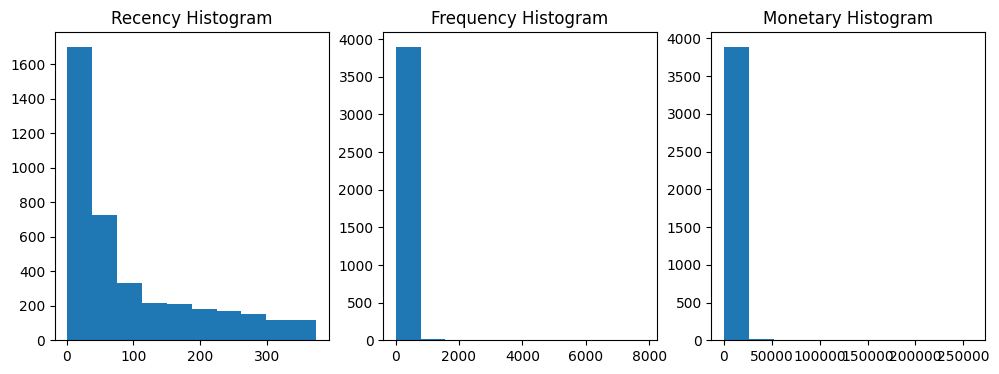

In [29]:
# 히스토그램으로 분포도 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()


In [30]:
# 기초 통계 정보 확인
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

# Recency
# - 평균이 92.742092로 50%(중위값 2/4)인 51 보다 크게 높음
# - max 값은 374로 75%(3/4)인 143보다  커서
# - 왜곡 정도가 어느 정도 있음을 알 수 있음

# Frequency
# - 왜곡 정도가 더 심함
# - 평균이 90.38인데 75% 99.25
# - 이유 : max 값 7847을 포함한 상위 몇 개의 큰 값 때문이라 판단됨

# Monetary
# - 마찬가지로 왜곡 정도가 매우 심함
# - 평균 1864로 75%인 1576 보다 훨씬 큼
# - 이유 : max 값 259,657를 포함한 상위 몇 개의 큰 값으로 인해 발생한 현상으로 보임 

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


### 온라인 판매 데이터 세트 특징
- 개인 고객 주문 + 소매점 주문


### 왜곡 정도가 매우 높은 데이터 세트에
- K-평균 군집을 적용하면  
    - 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨  

    - 그래서 먼저 평균과 표준편차 재조정한 뒤에 K-평균 수행  
        - (StandardScaler 사용해서 표준화해서 변환)   

### K-Means로 군집화 후에 실루엣 계수 평가
- (1) 왜곡정도가 심한 데이터를 그대로 사용할 경우  
- (2) 표준화 변환 수행후 군집화¶  

#### (1) 왜곡정도가 심한 데이터를 그대로 사용해서 실루엣 계수 확인

In [31]:
# 군집화 수행 : 군집 개수 4개로 구성

from sklearn.cluster import KMeans

X_features = cust_df[["Recency", "Frequency", "Monetary"]].values

kmeans = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=0)
labels = kmeans.fit_predict(X_features)

In [32]:
labels

array([2, 0, 2, ..., 0, 0, 0], shape=(3920,), dtype=int32)

In [33]:
# 실루엣 스코어 출력 : labels 값을 cust_df에 컬럼으로 추가 

from sklearn.metrics import silhouette_score


cust_df['cluster_label1'] = labels
print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features, labels)))


# 실루엣 스코어 : 0.839
# 왜곡 정도가 매우 심한 데이터 세트인데 
# 높은 실루엣 계수가 산출됨 : 이상치에 반응해서 과적합이 발생한 것으로 간주
# 왜곡도 심한 데이터 세트로 K-평균 군집을 적용하면
# 변별력이 떨어지는 군집화가 수행될 수 있음

# -> 실루엣 계수 절대적 수치 보다는
# -> 개별 군집의 균일도도 같이 확인해야 함

# 먼저 평균과 표준편차를 재조정한 후 
# K-평균 군집화 재 수행 



실루엣 스코어 : 0.839


#### (2) 표준화 변환 수행후 군집화

In [34]:
# StandardScaler 사용해서 표준 변환 수행

from sklearn.preprocessing import StandardScaler

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)
X_features_scaled[:3]

array([[ 2.3438109 , -0.41044983, 10.06690642],
       [-0.90174217,  0.05791145,  0.31163688],
       [-0.92183848, 20.68417459,  4.25767546]])

In [35]:
# 군집화 재 수행 : 군집 5개로 구성
X_features = cust_df[['Recency','Frequency','Monetary']].values
kmeans = KMeans(n_clusters=5, n_init=10, init='k-means++', max_iter=300, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


실루엣 스코어 : 0.616


In [36]:
# 군집화 재 수행 : 군집 4개로 구성
X_features = cust_df[['Recency','Frequency','Monetary']].values
kmeans = KMeans(n_clusters=4, n_init=10, init='k-means++', max_iter=300, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어 : 0.595


In [37]:
# 군집화 재 수행 : 군집 3개로 구성
X_features = cust_df[['Recency','Frequency','Monetary']].values
kmeans = KMeans(n_clusters=3, n_init=10, init='k-means++', max_iter=300, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어 : 0.592


In [38]:
# 군집 개수에 따른 실루엣 스코어
# 3 : 0.592
# 4 : 0.595
# 5 : 0.616

# 표준화한 후 실루엣 스코어는 더 떨어졌고
# 군집의 개수에 따라서 크게 편차가 없음을 확인
# --> 실루엣 계수만으로는 군집화가 더 잘되었다고 판단할 수 없음
# --> 시각화해서 실루엣 계수뿐 아니라 
# --> 균일도를 같이 확인할 필요가 있음

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

### K-Means 군집화 후에 실루엣 계수 및 군집을 시각화
- (1) 왜곡된 데이터인데 로그 변환 수행하지 않고 군집화 후 실루엣 계수 평가   
- (2) 로그 변환 수행하고 군집화 후 실루엣 계수 평가    

visualize_silhouette() 함수와 visualize_kmeans_plot_multi() 함수 사용

visualize_silhouette()
- 군집 개수를 변화시키면서 K-평균 군집을 수행했을 때
- 개별 군집별 평균 실루엣 계수 값을 시각화하는 함수 (앞에서 사용했음)

visualize_kmeans_plot_multi() 
- 군집 개수별로 군집화 구성을 시각화하는 함수

#### (1) 왜곡된 데이터인데 로그 변환 수행하지 않고 군집화 후 실루엣 계수 평가  

In [40]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):        
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters=n_cluster, n_init=10, init='k-means++', max_iter=500, 
                           random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
    plt.show()

In [41]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, n_init=10, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'd', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

### 실루엣 계수 / 군집화 그래프 출력
- (1) 표준화만 수행한 데이터 사용해서 군집화  
- (2) 로그 변환 수행 후 군집화 

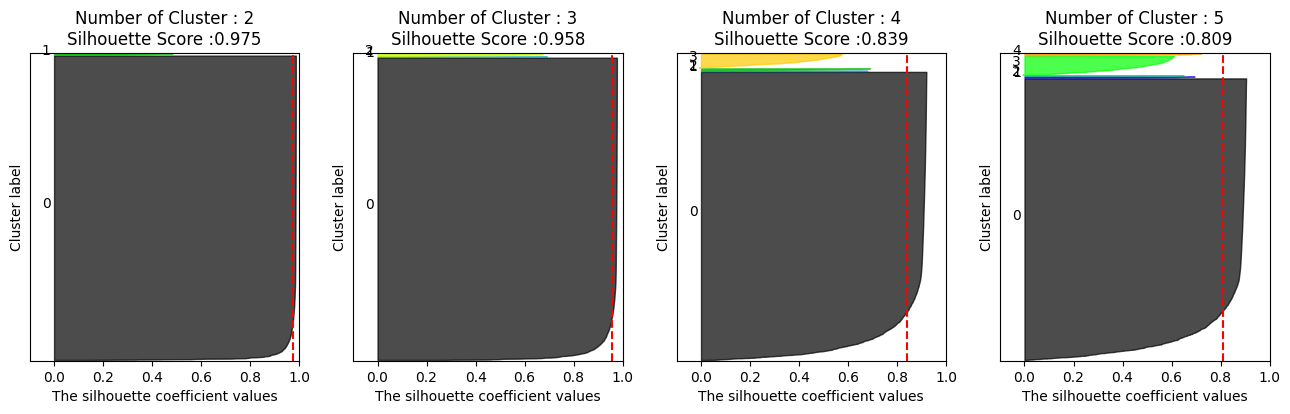

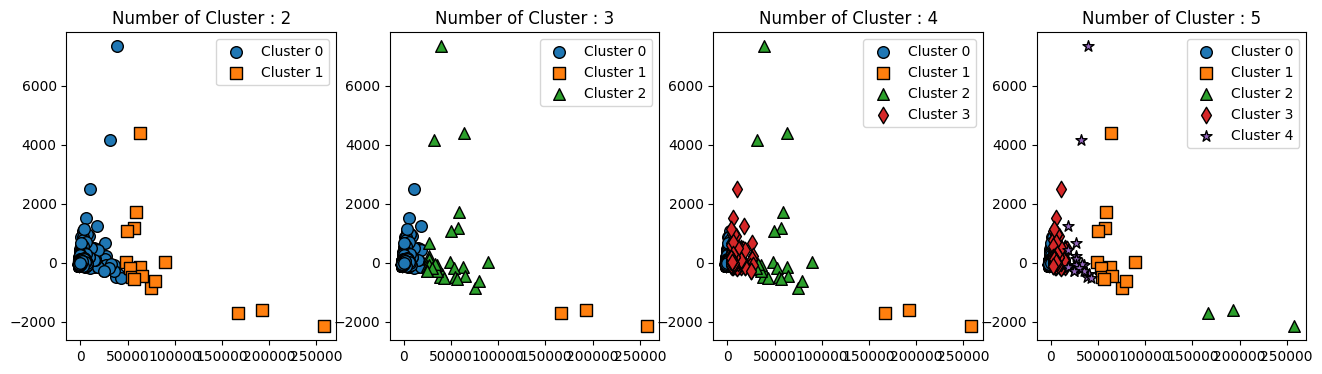

In [42]:
# (0) 왜도가 심한 원데이터 
# 실루엣 계수 / 군집화 그래프 출력 함수 호출
visualize_silhouette([2, 3, 4, 5], X_features)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features)

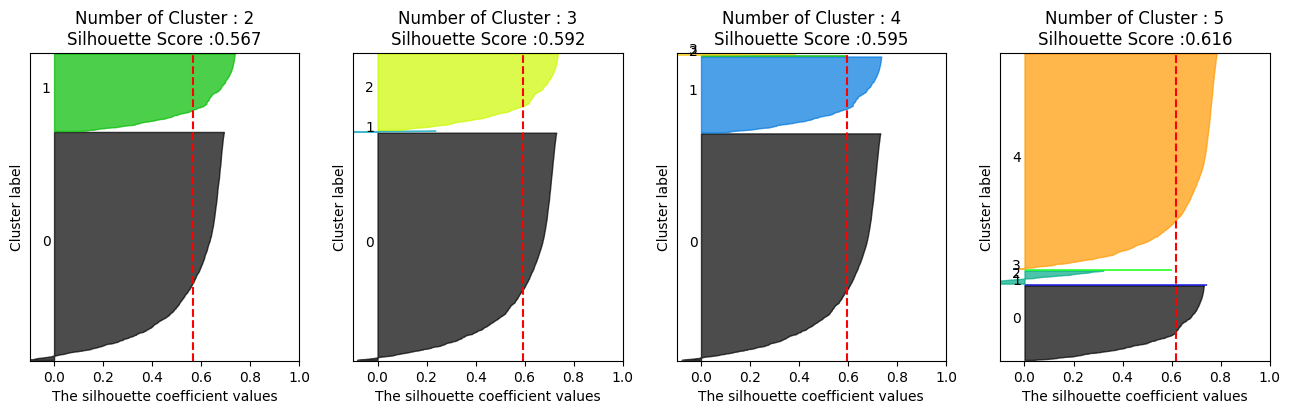

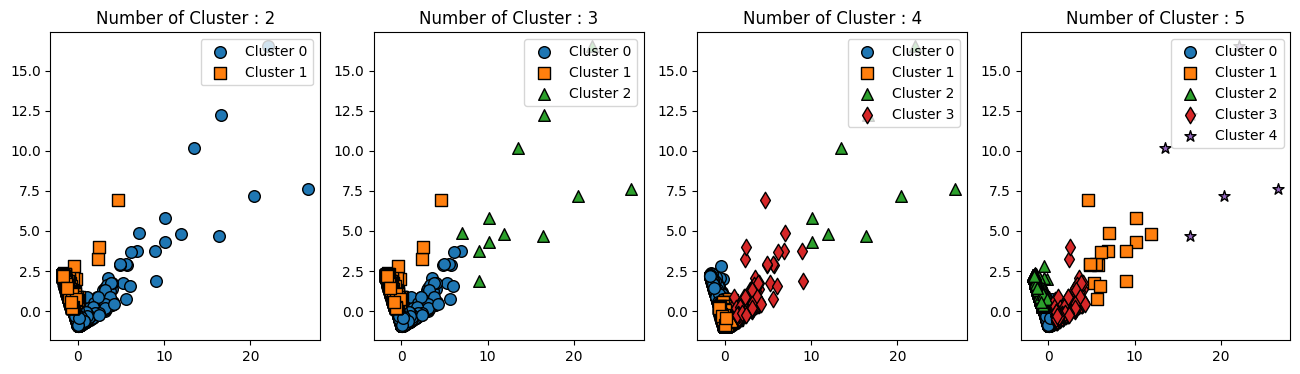

In [43]:
# (1) 표준화만 수행한 데이터 사용해서 군집화 : 로그변환 수행하지 않고 시각화
# 실루엣 계수 / 군집화 그래프 출력 함수 호출
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

### 왜곡된 데이터에 로그 변환 수행
 

### (2) 로그 변환 수행하고 군집화 후 실루엣 계수 평가
- 로그 변환 / StandardScale 수행 

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [44]:
cust_df.head(2)

,CustomerID,Recency,Frequency,Monetary,cluster_label1,cluster_label
0,12346,326,1,77183.60,2,1
1,12747,3,103,4196.01,0,0


In [45]:
# 로그 변환 수행
cust_df_log = np.log1p(cust_df[['Recency', 'Frequency', 'Monetary']])

In [47]:
cust_df.head(2)
cust_df_log

,CustomerID,Recency,Frequency,Monetary,cluster_label1,cluster_label
0,12346,326,1,77183.60,2,1
1,12747,3,103,4196.01,0,0


,Recency,Frequency,Monetary
0,5.789960,0.693147,11.253955
1,1.386294,4.644391,8.342128
2,0.693147,8.432942,10.425868
3,1.609438,5.298317,8.316760
4,1.609438,4.094345,6.849427
...,...,...,...
3915,5.631212,2.397895,5.201806
3916,5.204007,2.079442,4.404522
3917,2.197225,2.564949,5.187665
3918,1.609438,6.629363,7.647729


In [48]:
# 로그 변환된 데이터 StandardScaler 적용
X_features = cust_df_log[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

X_features_scaled[:3]

array([[ 1.48161832, -2.40338709,  3.78591383],
       [-1.88997639,  0.73257781,  1.44428   ],
       [-2.42067319,  3.73941895,  3.1199826 ]])

In [49]:
X_features_scaled

array([[ 1.48161832, -2.40338709,  3.78591383],
       [-1.88997639,  0.73257781,  1.44428   ],
       [-2.42067319,  3.73941895,  3.1199826 ],
       ...,
       [-1.26910093, -0.91780272, -1.09247605],
       [-1.71913018,  2.30798143,  0.88585825],
       [-0.05406709,  0.42962703,  0.78039553]], shape=(3920, 3))

In [59]:
# 군집화 수행

# 군집화 재 수행 : 군집 4개로 구성
X_features = X_features_scaled
kmeans = KMeans(n_clusters=4, n_init=10, init='k-means++', max_iter=300, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label4'] = labels

print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

# 결과
# 실루엣 계수가 로그 변환하기 전보더 더 떨어짐
# 그러나 실루엣 계수의 절대치가 절대적으로 중요한 것은 아니고
# 개별 군집이 얼마나 더 균일하게 군집화되었는지가 더 중요
# -> 균일도와 그래프 확인 

실루엣 스코어 : 0.306


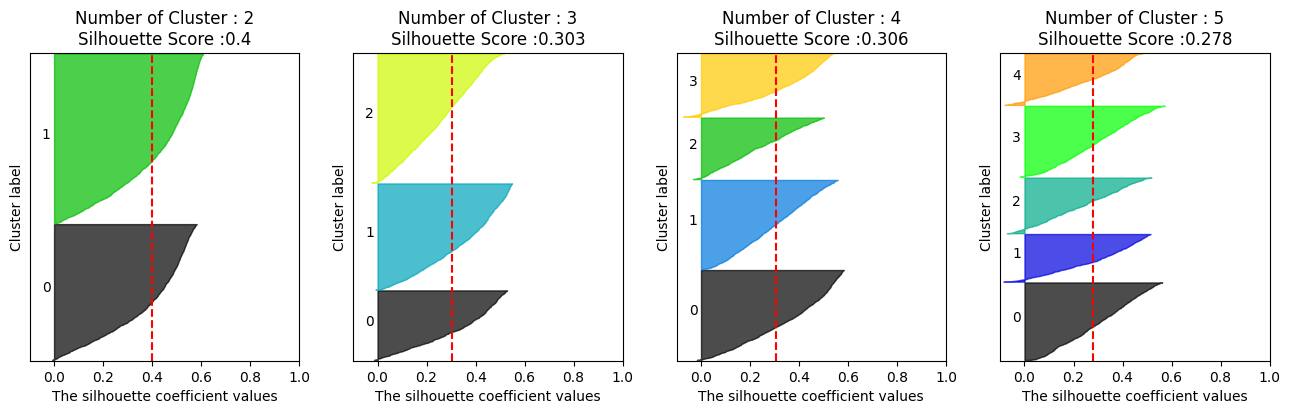

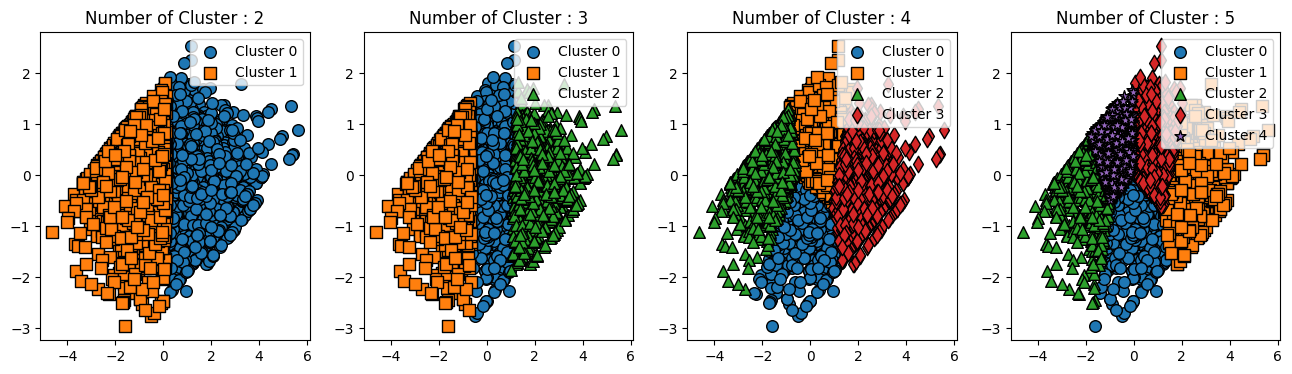

In [60]:
# 로그 변환된 데이터 세트로 실루엣 계수와 군집화 구성 시각화

# 실루엣 계수 / 군집화 그래프 출력 함수 호출
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

# 결과
# 실루엣 계수는 로그 변환 전 보다 더 떨어졌지만
# 균일하게 군집화가 구성된 것을 확인할 수 있음
# 실루엣 계수 절대치보다 개별 군짐의 균일도도 같이 확인해야 함

# 결론
# 왜곡된 데이터 세트에 대해서는
# 로그 변환 수행해서 데이터를 변환한 후에
# 군집화를 수행하면 더 나은 결과를 도출할 수 있음 

In [61]:
cust_df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_label1,cluster_label,cluster_label3,cluster_label4
0,12346,326,1,77183.60,2,1,2,1
1,12747,3,103,4196.01,0,3,0,3
2,12748,1,4595,33719.73,2,3,0,3
3,12749,4,199,4090.88,0,3,0,3
4,12820,4,59,942.34,0,3,0,3


In [64]:
cust_df['cluster_label4'].value_counts()

cluster_label4
0    1160
1    1151
3     816
2     793
Name: count, dtype: int64

#### 군집 수 결정 
- 엘보우 분석
- kmeans.inertia_
    - 군집 중심점으로부터 군집 내 데이터까지의 거리에 대한 제곱합
    - 합이 적을수록 군집 내 거리가 가깝게 모여있다는 의미
    - 군집수가 증가하면서 데이터들이 각 중심점에 가까워지기 때문에 inertia는 줄어들게 됨
        - 급격하게 감소하다가 완만하게 감소하게 되는 지점 : 엘보우의 포인트의 시작점으로 봄
        - 엘보우 포인트의 시작점을 지나서 완만하게 감소되기 시작하는 지점 : 엘보우 포인트 중점
        - 엘보우 포인트 중점을 적정 클러스터 수 k 로 지정하게되는 경우가 많다

KMeans(n_clusters=1, random_state=0)

KMeans(n_clusters=2, random_state=0)

KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=4, random_state=0)

KMeans(n_clusters=5, random_state=0)

KMeans(n_clusters=6, random_state=0)

KMeans(n_clusters=7, random_state=0)

KMeans(random_state=0)

KMeans(n_clusters=9, random_state=0)

KMeans(n_clusters=10, random_state=0)

Text(0.5, 0, 'cluster')

Text(0, 0.5, 'SSE')

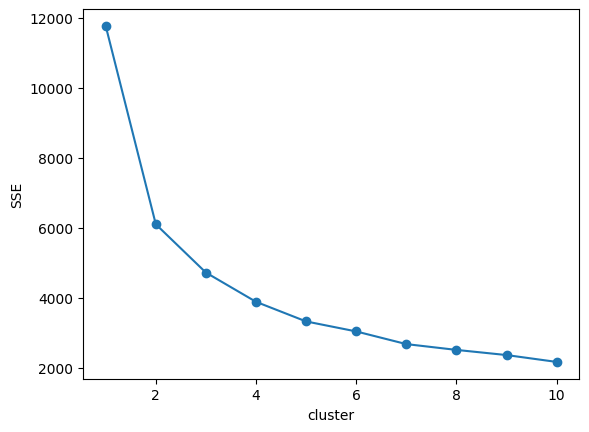

In [65]:
sse = []
for k in range(1,11) :
    kmeans=KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_features_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1,11),sse,marker='o')
plt.xlabel('cluster')
plt.ylabel('SSE')
plt.show()

- 2에서 팔꿈치가 생겨서 3~4가 중앙으로 보임
    - 최적 군집 수는 위 그래프에 의해서는 3~4개가 적당하다 판단 가능
    - 다만, 반드시 그런 것은 아님

### 군집결과 확인
- 군집 특징 간단 해설
    - 4개 군집으로 구성 후 특징 분석

In [68]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10, init="k-means++")
labels = kmeans.fit_predict(X_features_scaled)

In [102]:
cust_fin = cust_df1.copy()
cust_fin["cluster"] = labels
cust_fin

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346,326,1,77183.60,1
1,12747,3,103,4196.01,3
2,12748,1,4595,33719.73,3
3,12749,4,199,4090.88,3
4,12820,4,59,942.34,3
...,...,...,...,...,...
3915,18280,278,10,180.60,0
3916,18281,181,7,80.82,0
3917,18282,8,12,178.05,2
3918,18283,4,756,2094.88,3


In [104]:
clu_0 = cust_fin[cust_fin.cluster==0]
clu_1 = cust_fin[cust_fin.cluster==1]
clu_2 = cust_fin[cust_fin.cluster==2]
clu_3 = cust_fin[cust_fin.cluster==3]

### RFM 컬럼별로 군집별 차이 특성 파악
- 히스토그램 이용

(array([ 62., 180.,  91., 114., 129., 111., 163., 107., 102., 101.]),
 array([ 23. ,  58.1,  93.2, 128.3, 163.4, 198.5, 233.6, 268.7, 303.8,
        338.9, 374. ]),
 <BarContainer object of 10 artists>)

(array([395., 348., 150.,  87.,  65.,  44.,  23.,  16.,  14.,   9.]),
 array([ 15. ,  50.8,  86.6, 122.4, 158.2, 194. , 229.8, 265.6, 301.4,
        337.2, 373. ]),
 <BarContainer object of 10 artists>)

(array([123., 129., 162., 115.,  88.,  56.,  57.,  26.,  31.,   6.]),
 array([ 1. ,  8.5, 16. , 23.5, 31. , 38.5, 46. , 53.5, 61. , 68.5, 76. ]),
 <BarContainer object of 10 artists>)

(array([416., 230.,  84.,  52.,  21.,   9.,   3.,   0.,   0.,   1.]),
 array([ 1. ,  9.6, 18.2, 26.8, 35.4, 44. , 52.6, 61.2, 69.8, 78.4, 87. ]),
 <BarContainer object of 10 artists>)

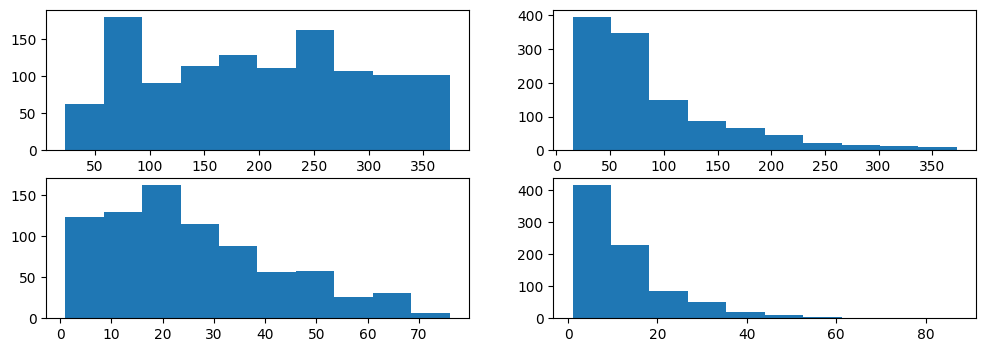

In [105]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=2, ncols=2)
ax[0, 0].hist(clu_0.Recency)
ax[0, 1].hist(clu_1.Recency)
ax[1, 0].hist(clu_2.Recency)
ax[1, 1].hist(clu_3.Recency)
plt.show()

(array([444., 325., 222.,  94.,  32.,  22.,   9.,   7.,   3.,   2.]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. , 51.4, 59.8, 68.2, 76.6, 85. ]),
 <BarContainer object of 10 artists>)

(array([432., 456., 175.,  57.,  16.,   8.,   4.,   2.,   0.,   1.]),
 array([  1. ,  55.2, 109.4, 163.6, 217.8, 272. , 326.2, 380.4, 434.6,
        488.8, 543. ]),
 <BarContainer object of 10 artists>)

(array([169., 238., 182.,  90.,  67.,  18.,  14.,   9.,   3.,   3.]),
 array([  1. ,  13.7,  26.4,  39.1,  51.8,  64.5,  77.2,  89.9, 102.6,
        115.3, 128. ]),
 <BarContainer object of 10 artists>)

(array([790.,  18.,   3.,   2.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([3.0000e+00, 7.8740e+02, 1.5718e+03, 2.3562e+03, 3.1406e+03,
        3.9250e+03, 4.7094e+03, 5.4938e+03, 6.2782e+03, 7.0626e+03,
        7.8470e+03]),
 <BarContainer object of 10 artists>)

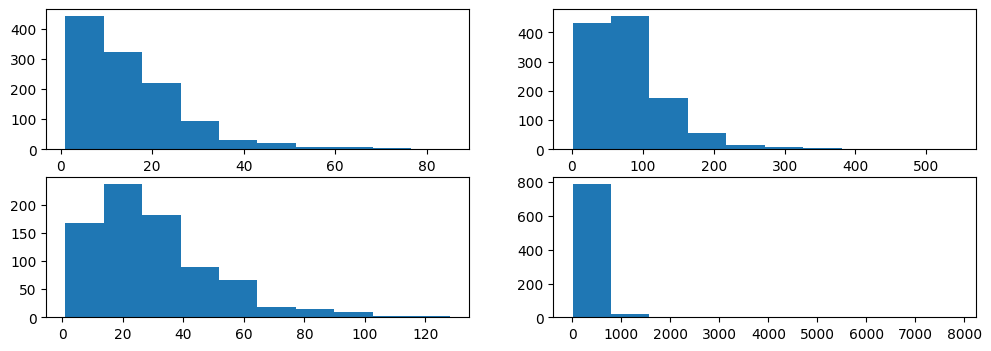

In [106]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=2, ncols=2)
ax[0, 0].hist(clu_0.Frequency)
ax[0, 1].hist(clu_1.Frequency)
ax[1, 0].hist(clu_2.Frequency)
ax[1, 1].hist(clu_3.Frequency)
plt.show()

(array([935., 194.,  17.,   5.,   6.,   1.,   0.,   1.,   0.,   1.]),
 array([3.750000e+00, 4.089470e+02, 8.141440e+02, 1.219341e+03,
        1.624538e+03, 2.029735e+03, 2.434932e+03, 2.840129e+03,
        3.245326e+03, 3.650523e+03, 4.055720e+03]),
 <BarContainer object of 10 artists>)

(array([1.146e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  233.81 ,  7928.789, 15623.768, 23318.747, 31013.726, 38708.705,
        46403.684, 54098.663, 61793.642, 69488.621, 77183.6  ]),
 <BarContainer object of 10 artists>)

(array([667., 110.,  12.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([  35.4 ,  706.74, 1378.08, 2049.42, 2720.76, 3392.1 , 4063.44,
        4734.78, 5406.12, 6077.46, 6748.8 ]),
 <BarContainer object of 10 artists>)

(array([787.,  16.,   8.,   2.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([   452.24 ,  26372.746,  52293.252,  78213.758, 104134.264,
        130054.77 , 155975.276, 181895.782, 207816.288, 233736.794,
        259657.3  ]),
 <BarContainer object of 10 artists>)

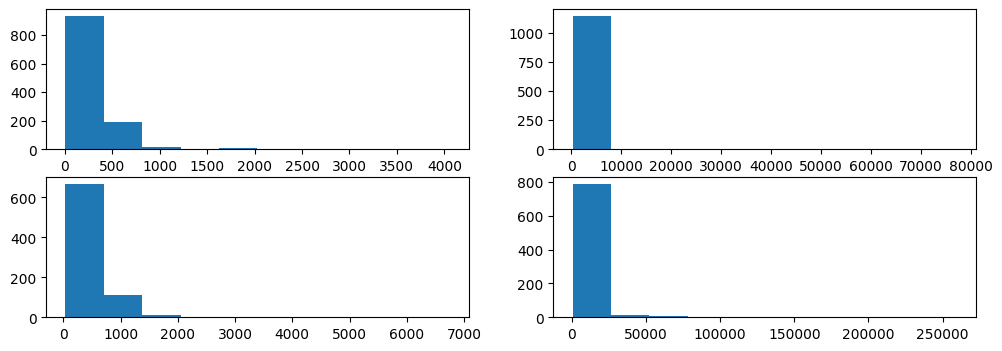

In [107]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=2, ncols=2)
ax[0, 0].hist(clu_0.Monetary)
ax[0, 1].hist(clu_1.Monetary)
ax[1, 0].hist(clu_2.Monetary)
ax[1, 1].hist(clu_3.Monetary)
plt.show()

#### 0번 군집 : 최근 구매일이 상대적으로 오래되었고, 구매빈도와 금액이 상대적으로 낮은 집단
        - 사이트와 거래를 더이상하고 있지 않은 개인 고객으로 추정
#### 1번 군집 : 최근 구매일이 오래되었고, 구매빈도와 금액이 0번에 비해 높은 집단
        - 사이트와 거래하고 있지 않은 소매상과 개인고객중 구매금액이 높은 집단
#### 2번 군집 : 최근 구매일이 오래되지 않은 구매빈도와 금액이 상대적으로 낮은 집단
        - 사이트와 거래하고 있는 개인고객으로 추정
#### 3번 군집 : 최근에도 구매가 있고, 구매빈도와 금액이 상대적으로 높은 집단(가장 높다)
        - 사이트와 그래하고 있는 소매장고객으로 추정(개인 고객 중 구매금액이 높은 고객도 포함되어 있을 것으로)

데이터 분석 도메인
- 특정 분야의 전문화된 지식. 데이터가 발생한 환경에 관한 지식  
- 데이터 사이언스를 통해서 해결하고자 하는 문제가 속한 업계, 산업에 대한 전문성을 의미
  - 예 : 병원 데이터 : 병원 관련 도메인 지식 
- 도메인 지식이 있는 사람들을 해당 분야의 전문가로 간주

- 우리의 경우 전문가라고 할 수는 없지만
- 데이터 분석할 때 주어진 데이터의 도메인을 해석하려고 노력은 해야 함


- 예로 상품 판매 데이터를 분석하려고 하면
  - 당연히 상품에 관련 데이터를 확인하고
  - 고객 데이터도 분석하고
  - 관련 매출 관련 행태도 분석해야 함
- 이런 것들을 좀 더 관찰하고 분석할 때
- 도메인 지식을 얻을 수 있음 

- 도메인 지식 예
  - 고객 
    - 성별, 나이, 거주지, 직업
    - 소득, 신용도, 계정 등 
    
  - 상품 
    - 가격, 특성
    
  - 주문
    - 주문 건수, 주문 금액, 평균 구매액, 구매 주기, 최근 구매 여부 등 
    
- 이러한 정보들을 확인하고
- 이러한 정보들이 주어져 있지 않다면 
- 가공해서 추출 